In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [43]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json
import random
from collections import defaultdict
import datetime

In [8]:
harris_file = '/content/drive/MyDrive/[인공지능기초]/analysis/youtube/harris_youtube_comment.jsonl'
trump_file = '/content/drive/MyDrive/[인공지능기초]/analysis/youtube/trump_youtube_comment.jsonl'

## 댓글 게시 날짜 확인

In [19]:
def extract_published_at(file_path):
    published_at_values = set()

    with open(file_path, 'r') as file:
        for line in file:
            comment = json.loads(line)
            published_at_values.add(comment['publishedAt'])

    return published_at_values

In [17]:
harris_dates = extract_published_at(harris_file)
trump_dates = extract_published_at(trump_file)

# Combine the unique values from both files
all_dates = harris_dates.union(trump_dates)

# Convert to datetime objects and extract the date part only
date_only = {datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ').date() for date in all_dates}

# Sort the dates
sorted_dates = sorted(date_only)

# Output the sorted dates
print("Sorted 'publishedAt' dates:")
for date in sorted_dates:
    print(date)

Sorted 'publishedAt' dates:
2024-07-21
2024-07-22
2024-07-23
2024-07-24
2024-07-25
2024-07-26
2024-07-27
2024-07-28
2024-07-29
2024-07-30
2024-07-31
2024-08-01
2024-08-02
2024-08-03
2024-08-04
2024-08-05
2024-08-06
2024-08-07
2024-08-08
2024-08-09
2024-08-10
2024-08-11
2024-08-12
2024-08-13
2024-08-14
2024-08-15
2024-08-16
2024-08-17
2024-08-18
2024-08-19
2024-08-20
2024-08-21
2024-08-22
2024-08-23
2024-08-24
2024-08-25
2024-08-26
2024-08-27
2024-08-28
2024-08-29
2024-08-30
2024-08-31
2024-09-01
2024-09-02
2024-09-03
2024-09-04
2024-09-05
2024-09-06
2024-09-07
2024-09-08
2024-09-09
2024-09-10
2024-09-11
2024-09-12
2024-09-13
2024-09-14
2024-09-15
2024-09-16
2024-09-17
2024-09-18
2024-09-19
2024-09-20
2024-09-21
2024-09-22
2024-09-23
2024-09-24
2024-09-25
2024-09-26
2024-09-27
2024-09-28
2024-09-29
2024-09-30
2024-10-01
2024-10-02
2024-10-03
2024-10-04
2024-10-05
2024-10-06
2024-10-07
2024-10-08
2024-10-09
2024-10-10
2024-10-11
2024-10-12
2024-10-13
2024-10-14
2024-10-15
2024-10-16
2024

## 정규화 방법 1: 비율 기반 가중치

In [21]:
def date_from_str(date_str):
    return datetime.datetime.fromisoformat(date_str.replace("Z", "")).date()

In [22]:
with open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/harris_youtube_comment.jsonl', 'r') as f:
    harris_data = [json.loads(line) for line in f]

with open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/trump_youtube_comment.jsonl', 'r') as f:
    trump_data = [json.loads(line) for line in f]

In [23]:
# 전체 댓글 수
N_H = len(harris_data)  # 96,987
N_T = len(trump_data)    # 223,578

In [24]:
# 비율 계산
trump_weight = N_H / N_T  # 약 0.433

# VADER 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

In [25]:
# 날짜별 합산용 구조
harris_daily_scores = defaultdict(list)
trump_daily_scores = defaultdict(list)

## VADER 기반 감성분석

- 비율 기반 가중치 정규화 이후 감정 분석

In [26]:
# 해리스 채널 감성 분석
for d in harris_data:
    day = date_from_str(d["publishedAt"])
    score = analyzer.polarity_scores(d["textDisplay"])["compound"]
    harris_daily_scores[day].append(score)

In [27]:
# 트럼프 채널 감성 분석
for d in trump_data:
    day = date_from_str(d["publishedAt"])
    score = analyzer.polarity_scores(d["textDisplay"])["compound"]
    trump_daily_scores[day].append(score)

In [28]:
# 일자별 평균 계산

# 해리스: 단순 평균
harris_daily_avg = {day: sum(scores)/len(scores) for day, scores in harris_daily_scores.items()}

# 트럼프: 단순 평균 후 비교 시 trump_weight를 곱해줌
trump_daily_raw_avg = {day: sum(scores)/len(scores) for day, scores in trump_daily_scores.items()}

In [29]:
# 비교 목적일 때는 trump_daily_avg = trump_daily_raw_avg * trump_weight
trump_daily_avg = {day: avg * trump_weight for day, avg in trump_daily_raw_avg.items()}

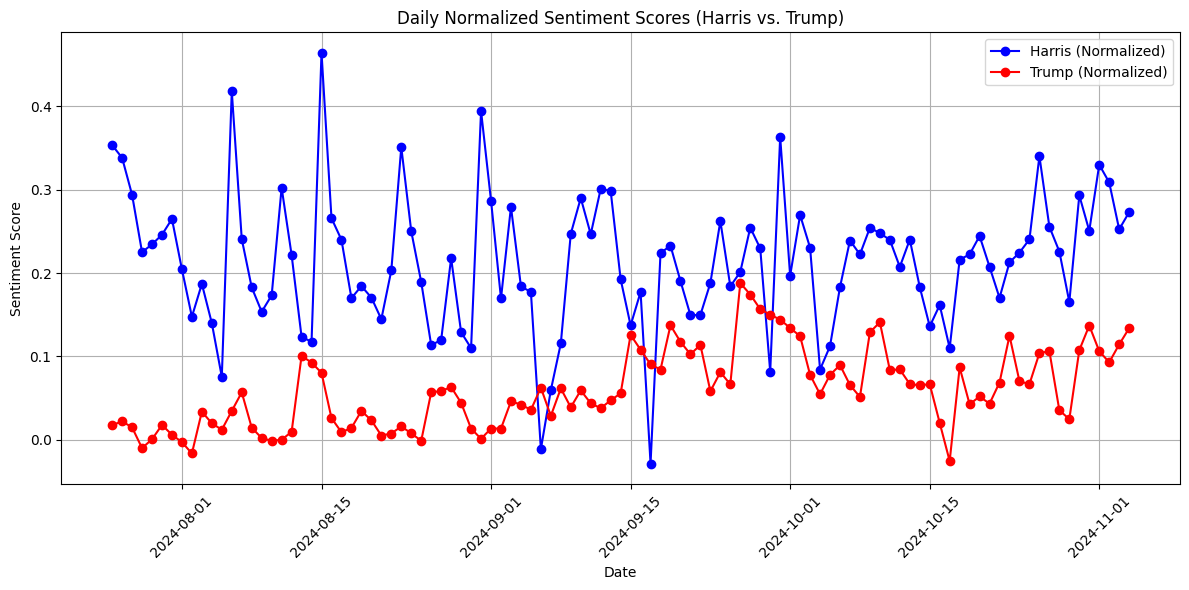

In [32]:
import matplotlib.pyplot as plt
from datetime import datetime

# 예시: harris_daily_avg, trump_daily_avg 딕셔너리가 다음과 같은 형태라고 가정
# harris_daily_avg = {date(2024, 7, 21): 0.1, date(2024, 7, 22): -0.05, ...}
# trump_daily_avg = {date(2024, 7, 21): 0.08, date(2024, 7, 22): -0.02, ...}

# 날짜 순으로 정렬
sorted_days = sorted(harris_daily_avg.keys())

harris_scores = [harris_daily_avg[d] for d in sorted_days]
# 트럼프 채널의 경우 해당 날짜가 없을 경우를 대비해 get 사용(필요시)
trump_scores = [trump_daily_avg.get(d, None) for d in sorted_days]

plt.figure(figsize=(12,6))
plt.plot(sorted_days, harris_scores, label='Harris (Normalized)', marker='o', color='blue')
plt.plot(sorted_days, trump_scores, label='Trump (Normalized)', marker='o', color='red')

plt.title('Daily Normalized Sentiment Scores (Harris vs. Trump)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 정규화 방법 2: 다운샘플링

In [33]:
harris_data = [json.loads(line) for line in open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/harris_youtube_comment.jsonl', 'r')]
trump_data = [json.loads(line) for line in open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/trump_youtube_comment.jsonl', 'r')]

In [34]:
harris_count = len(harris_data)     # 약 96,987
trump_count = len(trump_data)       # 약 223,578
# 트럼프 댓글을 해리스 댓글 수만큼 랜덤 추출
trump_data_downsampled = random.sample(trump_data, harris_count)

In [49]:
len(trump_data_downsampled)

96987

## VADER 기반 감성분석
- 다운샘플링 정규화 이후 감정 분석

In [35]:
# VADER 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

In [39]:
def date_from_str(date_str):
    return datetime.datetime.fromisoformat(date_str.replace("Z", "")).date()

In [40]:
# 날짜별 집계
harris_daily = defaultdict(list)
trump_daily = defaultdict(list)

In [44]:
for d in harris_data:
    day = date_from_str(d["publishedAt"])
    scores = analyzer.polarity_scores(d["textDisplay"])
    harris_daily[day].append(scores["compound"])

In [45]:
for d in trump_data_downsampled:
    day = date_from_str(d["publishedAt"])
    scores = analyzer.polarity_scores(d["textDisplay"])
    trump_daily[day].append(scores["compound"])

In [46]:
# 일자별 평균
harris_daily_avg = {day: sum(vals)/len(vals) for day, vals in harris_daily.items()}
trump_daily_avg = {day: sum(vals)/len(vals) for day, vals in trump_daily.items()}

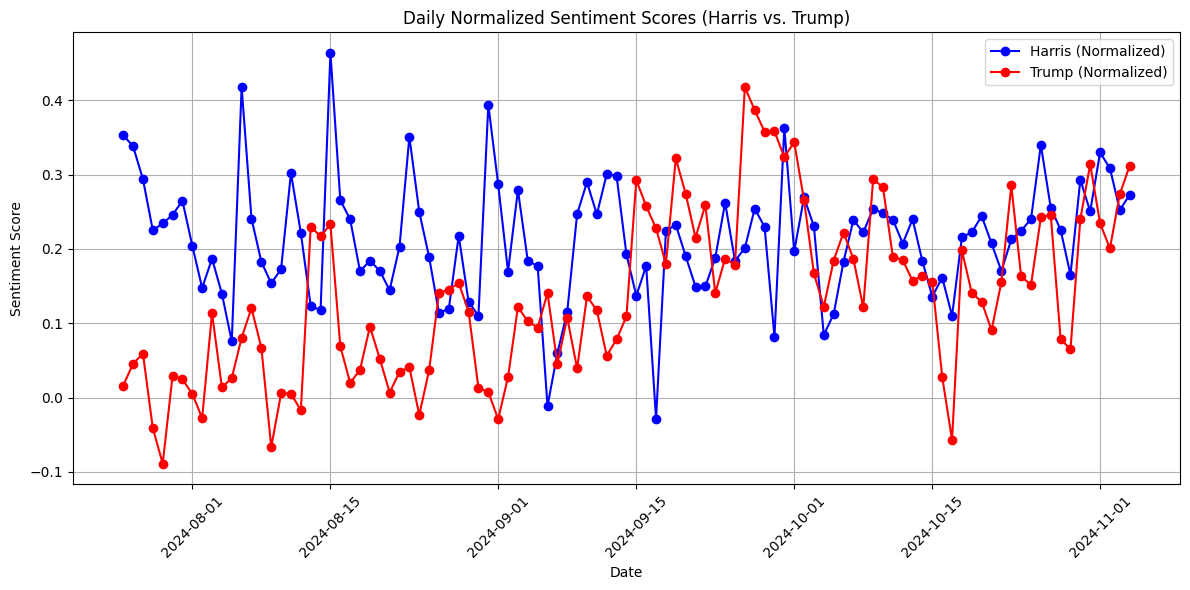

In [48]:
import matplotlib.pyplot as plt
from datetime import datetime

# 예시: harris_daily_avg, trump_daily_avg 딕셔너리가 다음과 같은 형태라고 가정
# harris_daily_avg = {date(2024, 7, 21): 0.1, date(2024, 7, 22): -0.05, ...}
# trump_daily_avg = {date(2024, 7, 21): 0.08, date(2024, 7, 22): -0.02, ...}

# 날짜 순으로 정렬
sorted_days = sorted(harris_daily_avg.keys())

harris_scores = [harris_daily_avg[d] for d in sorted_days]
# 트럼프 채널의 경우 해당 날짜가 없을 경우를 대비해 get 사용(필요시)
trump_scores = [trump_daily_avg.get(d, None) for d in sorted_days]

plt.figure(figsize=(12,6))
plt.plot(sorted_days, harris_scores, label='Harris (Normalized)', marker='o', color='blue')
plt.plot(sorted_days, trump_scores, label='Trump (Normalized)', marker='o', color='red')

plt.title('Daily Normalized Sentiment Scores (Harris vs. Trump)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
# 감성 분석 결과를 파일로 저장
with open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/vader_sentiment_analysis_harris.json', 'w') as f:
    # 날짜를 문자열로 변환하여 저장
    harris_daily_avg_str = {str(day): score for day, score in harris_daily_avg.items()}
    json.dump(harris_daily_avg_str, f)

with open('/content/drive/MyDrive/[인공지능기초]/analysis/youtube/vader_sentiment_analysis_trump.json', 'w') as f:
    # 날짜를 문자열로 변환하여 저장
    trump_daily_avg_str = {str(day): score for day, score in trump_daily_avg.items()}
    json.dump(trump_daily_avg_str, f)